##Libraries

In [ ]:
!pip install geopandas

In [ ]:
!pip install rasterio

In [ ]:
!pip install sentinelhub --upgrade

In [ ]:
!pip install --upgrade eo-learn

In [ ]:
#!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.animation as animation

import pickle as pkl

from enum import Enum

from shapely.geometry import Polygon

#from eolearn.io.local_io import *
from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling


# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, FeatureType, OverwritePermission, LoadTask, SaveTask, EOExecutor#, LinearWorkflow
from eolearn.io import SentinelHubInputTask, SentinelHubEvalscriptTask#, ExportToTiff
from eolearn.mask import CloudMaskTask#, AddValidDataMaskTask
from eolearn.geometry import ErosionTask#, VectorToRaster, PointSamplingTask
from eolearn.features import LinearInterpolationTask, SimpleFilterTask, InterpolationTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

from tqdm import tqdm 

import builtins
import os

%matplotlib inline

##Mounting Google Drive

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Paths

In [8]:
data_path = Path('/content/gdrive/My Drive/Colab Notebooks/Zindi')

In [9]:
output_path   = Path('/content/gdrive/My Drive/Colab Notebooks/Zindi/output')

In [10]:
shape_path    = output_path/'shapes'
patch_path    = output_path/'patches'
feature_path  = output_path/'features_filtered_clouds_allbands'

shape_path.mkdir(exist_ok=True, parents=True)
patch_path.mkdir(exist_ok=True, parents=True)
feature_path.mkdir(exist_ok=True, parents=True)

In [11]:
train_patchlet_path = output_path/'train_patchlets_filt_allbands'
test_patchlet_path = output_path/'test_patchlets_filt_allbands'

In [12]:
train_patchlet_path.mkdir(exist_ok=True, parents=True)
test_patchlet_path.mkdir(exist_ok=True, parents=True)

##Save training patchlets

In [16]:
#targ ~ mask
#feat ~ image
def save_samples(patch_path, patch_idx, out_path, size=64, sample_factor=25):
    
    patch_path = Path(patch_path)
    #print(patch_path)
    out_path = Path(out_path)
    print(out_path)
    out_path.mkdir(exist_ok=True, parents=True)
    
    patch = EOPatch.load(patch_path/f'eopatch_{patch_idx}')
    
    half_size = size//2
    #print("half_size", half_size)
    
    #targets = patch.mask_timeless['LULC']
    targets = patch.mask_timeless['LULC_TRAIN']
    
    patch_shape = targets.shape
    #print(targets.shape)
    #print(patch_shape)
    
    shape_x = patch_shape[0]
    shape_y = patch_shape[1]
    #print(shape_x)
    #print(shape_y)
    
    features = patch.data['FEATURES'] # R G B NIR NDVI NDWI NDBI NORM
    
    non_empty_targets = np.indices(patch_shape)[:,targets!=0]
    
    target_xs = non_empty_targets[0]
    target_ys = non_empty_targets[1]

    target_count = len(target_xs)
    #print(target_count)
    
    samples = (target_count*sample_factor)//(size**2)
    #print(samples)
    
    print(f'saving {samples} patchlets from patch {patch_idx}')

    for i in range(samples):
        index = np.random.randint(target_count)
        #print("index", index)
        
        x_offset = np.clip(target_xs[index], half_size, shape_x-half_size) # ensure sample won't exceed patch
        #print("x_offset", x_offset)
        y_offset = np.clip(target_ys[index], half_size, shape_y-half_size) # ensure sample won't exceed patch
        #print("y_offset", y_offset)
        
        targ_arr = targets [x_offset-half_size:x_offset+half_size, y_offset-half_size:y_offset+half_size,0]
        #print("targ_arr", targ_arr.shape)
        feat_arr = features[:,x_offset-half_size:x_offset+half_size, y_offset-half_size:y_offset+half_size,:]
        #print("feat_arr", feat_arr.shape)
        if (feat_arr.shape[1] != size or feat_arr.shape[2] != size):
          print("Exception: Cannot save patch_", patch_idx, "_x_", x_offset, "_y_", y_offset, "_feat.pkl")
          print("feat_arr", feat_arr.shape)
          continue
          
        
        targ_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl'
        feat_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_feat.pkl'
        
        pkl.dump(targ_arr, open(out_path/targ_fn,'wb'))
        pkl.dump(feat_arr, open(out_path/feat_fn,'wb'))
    
    del patch

In [ ]:
for patch_idx in tqdm(range(12)):
    save_samples(patch_path=feature_path, 
                 patch_idx=patch_idx, 
                 out_path=train_patchlet_path, 
                 size=64, 
                 sample_factor=25)

In [ ]:
print(len([name for name in os.listdir(train_patchlet_path) if os.path.isfile(os.path.join(train_patchlet_path, name))]))

##Visualize the targets and features per patchlet

In [19]:
class LULC(Enum):
    NO_DATA        = (0,  'No Data',          'black')
    COTTON         = (1,  'Cotton',           'xkcd:lime')
    GRASS          = (2,  'Grass',            'orange')
    LUCERN         = (3,  'Lucern',           'xkcd:tan')
    MAIZE          = (4,  'Maize',            'xkcd:azure')
    PECAN          = (5,  'Pecan',            'xkcd:lightblue')
    VACANT         = (6,  'Vacant',           'xkcd:beige')
    VINEYARD       = (7,  'Vineyard',         'crimson')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

In [20]:
# Reference colormap things
lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

In [ ]:
img = pkl.load(open('/content/gdrive/My Drive/Colab Notebooks/Zindi/output/train_patchlets_filt_allbands/patch_9_x_960_y_32_feat.pkl','rb'))
img_arr = np.array(img)
print('Size: ' + str(img_arr.shape))
print('Max = ' + str(img_arr.max()) + ' ; ' + 'Min = ' + str(img_arr.min()))
#print(img_arr)
print(np.unique(img_arr))
np.isnan(img_arr).any()

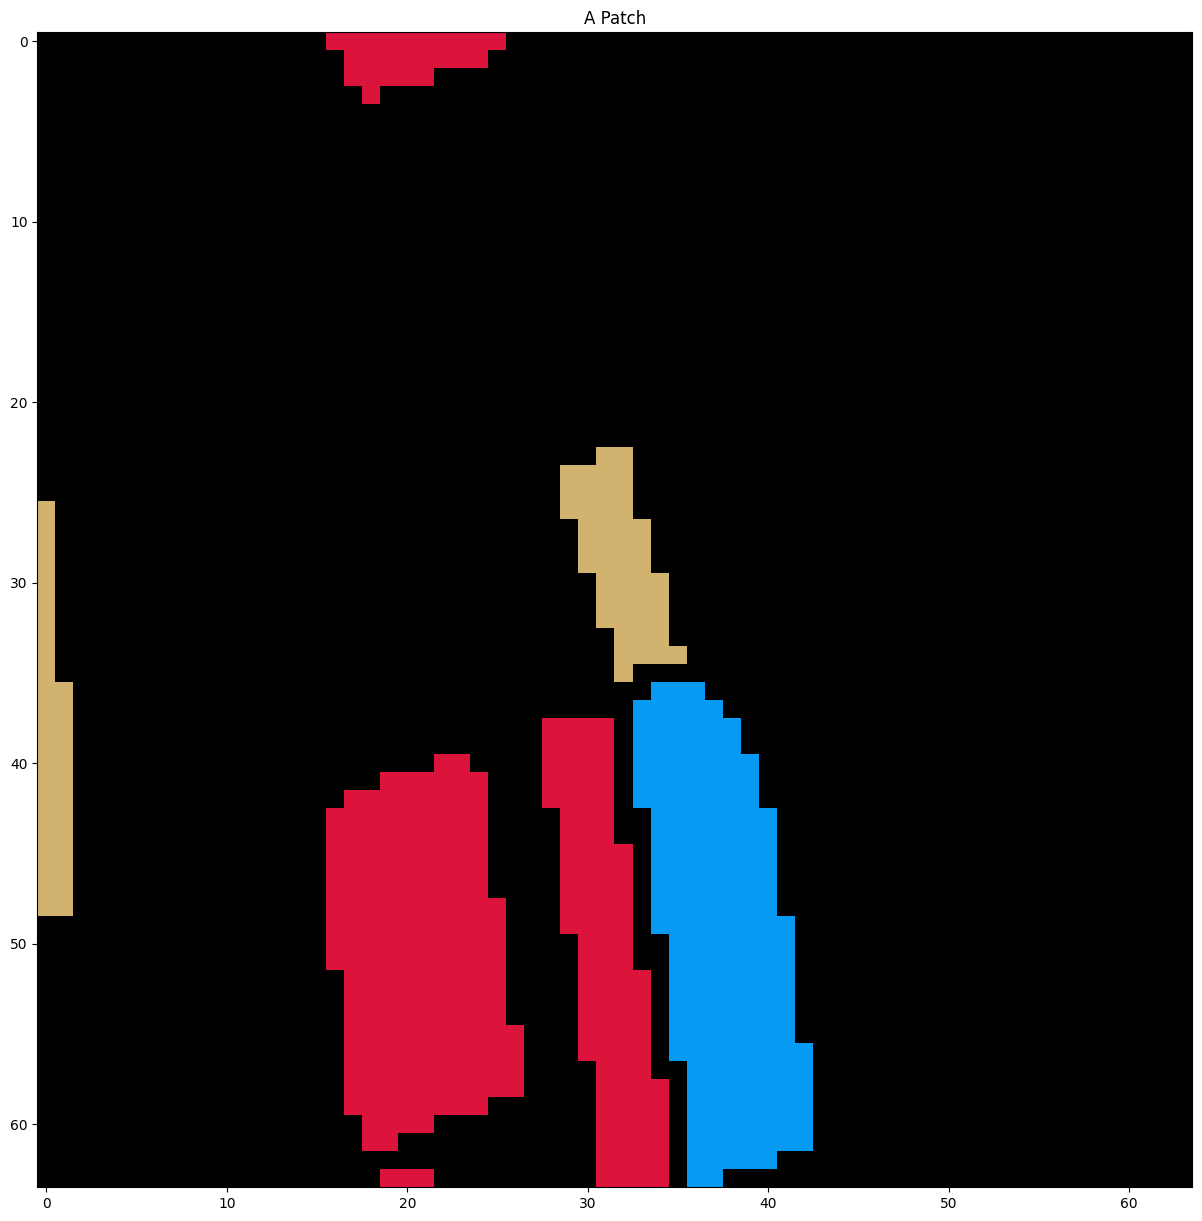

In [23]:
img = pkl.load(open('/content/gdrive/My Drive/Colab Notebooks/Zindi/output/train_patchlets_filt_allbands/patch_11_x_1313_y_527_targ.pkl','rb'))
plt.figure(figsize=(15,15))
plt.title('A Patch')
im=plt.imshow(img, cmap=lulc_cmap)
plt.show()

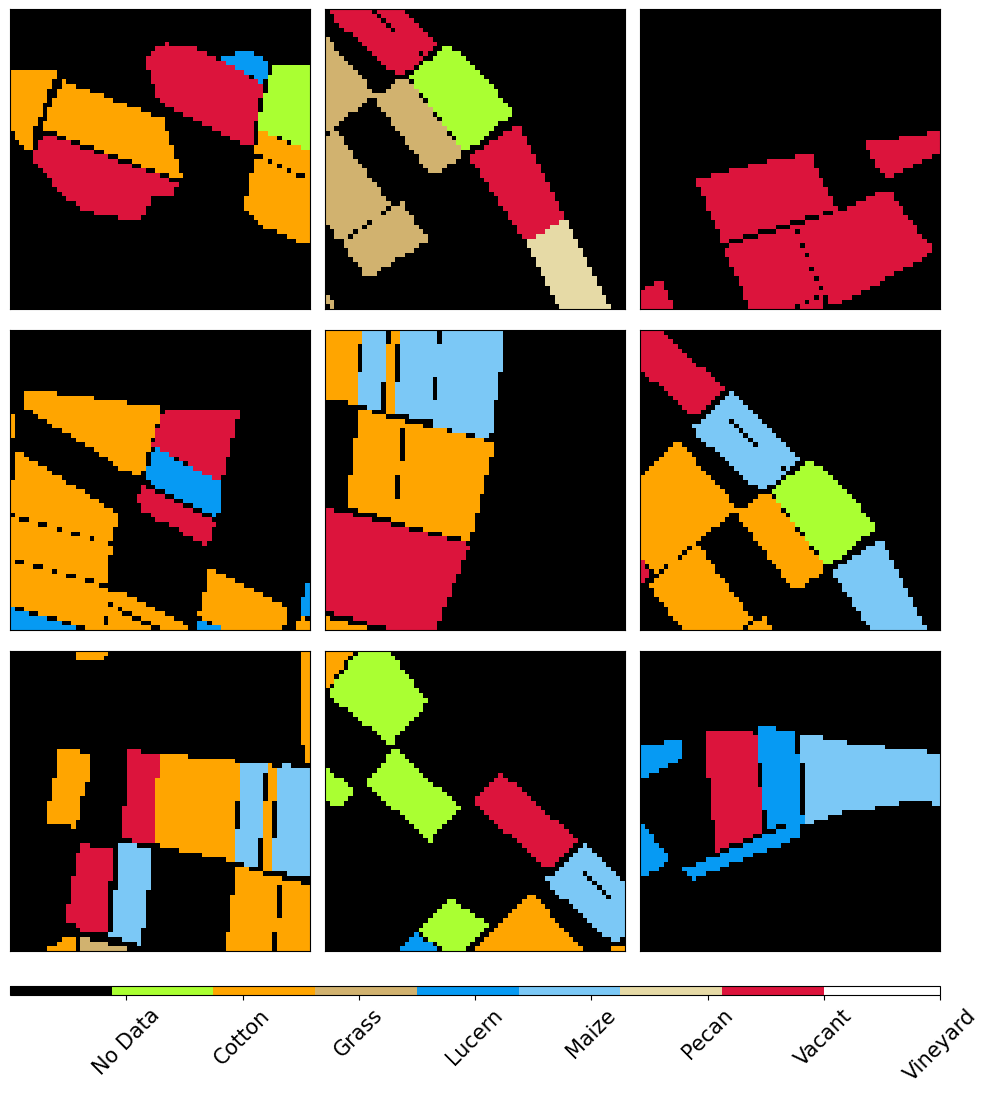

In [24]:
%matplotlib inline

targs = [str(f) for f in train_patchlet_path.glob('patch_9_*_targ.pkl')][:9]
#print(targs)

fig = plt.figure(figsize=(12,15))

for i,f in enumerate(targs):
    ax = plt.subplot(3, 3, i+1)
    targ = pkl.load(open(f,'rb'))
    im=plt.imshow(targ, cmap=lulc_cmap)
    plt.xticks([])
    plt.yticks([])
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.03, aspect=100)
cb.ax.tick_params(labelsize=15) 
cb.set_ticks([entry.id+1 for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

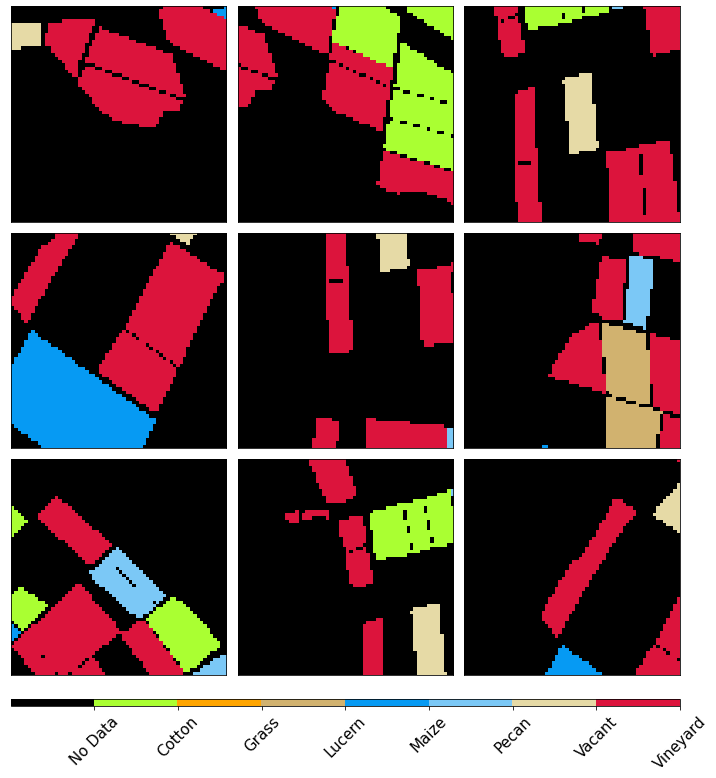

In [ ]:
%matplotlib inline

targs = [str(f) for f in train_patchlet_path.glob('patch_9_*_targ.pkl')][:9]
#print(targs)

fig = plt.figure(figsize=(12,15))

for i,f in enumerate(targs):
    ax = plt.subplot(3, 3, i+1)
    targ = pkl.load(open(f,'rb'))
    im=plt.imshow(targ, cmap=lulc_cmap)
    plt.xticks([])
    plt.yticks([])
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.03, aspect=100)
cb.ax.tick_params(labelsize=15) 
cb.set_ticks([entry.id+1 for entry in LULC])
cb.ax.set_xticklabels([entry.class_name for entry in LULC], rotation=45, fontsize=15)
plt.show()

In [ ]:
fps = 1
nSeconds = 8

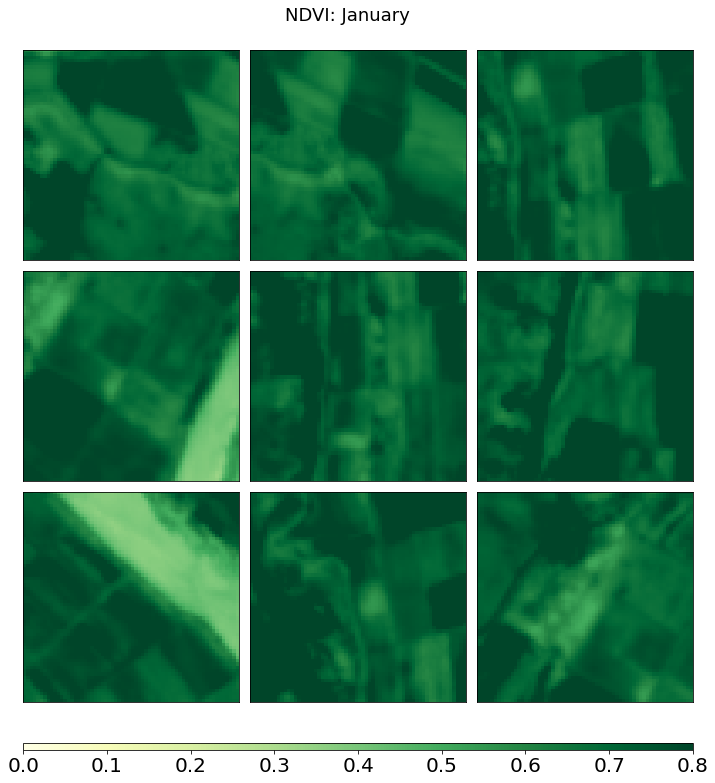

In [ ]:
fig, axes = plt.subplots(3,3,sharey=True,sharex=True, figsize=(12,15))
plt.xticks([])
plt.yticks([])

fig.subplots_adjust(wspace=0.05, hspace=0.05)

#feats = [str(f) for f in train_patchlet_path.glob('patch_10_*_feat.pkl')][:9]
feats = [str(f).replace('targ','feat') for f in targs]

datas = [[pkl.load(open(feat,'rb'))[i,...,-1] for i in range(8)] for feat in feats] # [i,...,-1] -2, -3 etc.

imgs = [axes[j//3,j%3].imshow(datas[j][0], interpolation='none', aspect='auto', 
                              vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
      for j in range(len(feats))]

cb = fig.colorbar(imgs[0], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, aspect=100)
cb.ax.tick_params(labelsize=20)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
def animate_func(i):
    fig.suptitle(f'NDVI: {months[i]}', y=0.92, size=18)
    for j in range(len(feats)):
        imgs[j].set_array(datas[j][i])
    return [imgs]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               repeat=True
                               )

anim.save(output_path/'nvdi.gif', writer=mpl.animation.PillowWriter(fps=fps, extra_args='loop:0'))

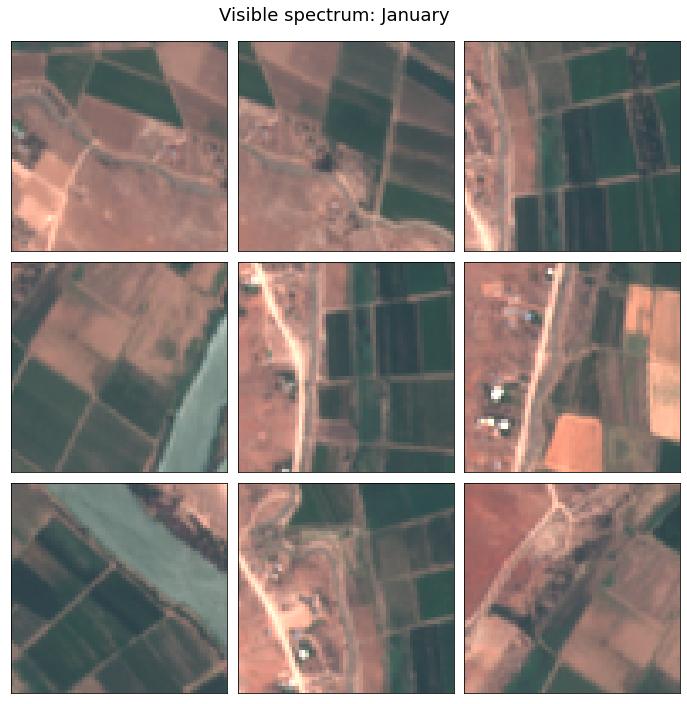

In [ ]:
fig, axes = plt.subplots(3,3,sharey=True,sharex=True, figsize=(12,12))
plt.xticks([])
plt.yticks([])

fig.subplots_adjust(wspace=0.05, hspace=0.05)
feats = [str(f).replace('targ','feat') for f in targs]

datas = [[np.clip(pkl.load(open(feat,'rb'))[i,...,0:3]*3.5,0,1) for i in range(8)] for feat in feats]

imgs = [axes[j//3,j%3].imshow(datas[j][0], interpolation='none', aspect='auto', cmap=plt.get_cmap('YlGn'), vmin=0, vmax=1) 
      for j in range(len(feats))]

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
def animate_func(i):
    fig.suptitle(f'Visible spectrum: {months[i]}', y=0.92, size=18)
    for j in range(len(feats)):
        imgs[j].set_array(datas[j][i])
    return [imgs]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               repeat=True
                               )

anim.save(output_path/'visible_spectrum.gif', writer=mpl.animation.PillowWriter(fps=fps))

##Make test dataset

In [25]:
def save_test_grid(patch_path, patch_idx, out_path, size=64):
    
    patch_path = Path(patch_path)
    out_path = Path(out_path)
    #out_lbls_path = Path(out_lbls_path)
    
    out_path.mkdir(exist_ok=True, parents=True)
    #out_lbls_path.mkdir(exist_ok=True, parents=True)
    
    patch = EOPatch.load(patch_path/f'eopatch_{patch_idx}')
    
    half_size = size//2
    
    test_field_ids = patch.mask_timeless['FIELD_ID_TEST']
    #test_field_ids = patch.mask_timeless['LULC_TEST']
    #print("test_field_ids", test_field_ids.shape)
    
    patch_shape = test_field_ids.squeeze().shape
    #print("patch_shape:", patch_shape)
    
    shape_x = patch_shape[0]
    #print("shape_x", shape_x)
    shape_y = patch_shape[1]
    #print("shape_y", shape_y)
    
    features = patch.data['FEATURES'] # R G B NDVI
    #print("features.shape", features.shape)

    c = (shape_x//size)+1
    #print("c", c)
    r = (shape_y//size)+1
    #print("r", r)

    for i in range(c):
        for j in range(r):
            x_offset = i*size
            #print("x_offset", x_offset)
            y_offset = j*size
            #print("y_offset", y_offset)
            
            field_id_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl'
            feat_fn     = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_feat.pkl'
            
            patchlet_field_ids = test_field_ids[x_offset:x_offset+size, 
                                                y_offset:y_offset+size,...]
            #print("patchlet_field_ids", patchlet_field_ids.shape)
        
            if patchlet_field_ids.max() > 0: #save patchlet only if there exists a field in it, i.e., maximum value (id) of any field is > 0.
                
                feat_arr = features[:,x_offset:x_offset+size, 
                                      y_offset:y_offset+size,:]
                #print("feat_arr", feat_arr.shape)
                
                if (patchlet_field_ids.shape[0] < size) or (patchlet_field_ids.shape[1] < size):
                    #print("in if")
                    short_x = size - patchlet_field_ids.shape[0]
                    #print("short_x", short_x)
                    short_y = size - patchlet_field_ids.shape[1]
                    #print("short_y", short_y)
                    
                    patchlet_field_ids = np.pad(patchlet_field_ids, 
                                                   ((0,short_x),(0,short_y),(0,0)), 
                                                   mode='constant', 
                                                   constant_values=0)
                    #print("patchlet_field_ids", patchlet_field_ids.shape)

                    feat_arr           = np.pad(feat_arr, 
                                                   ((0,0),(0,short_x),(0,short_y),(0,0)), 
                                                   mode='reflect')
                    
                    #print("feat_arr", feat_arr.shape)
                #if (feat_arr.shape[1] != 64 or feat_arr.shape[2] != 64):
                  #print("Exception: Cannot save patch")
                  #print("feat_arr", feat_arr.shape)
                  #continue

                pkl.dump(patchlet_field_ids, open(out_path/field_id_fn,'wb'))
                pkl.dump(feat_arr, open(out_path/feat_fn,'wb'))
    del patch

In [26]:
for i in tqdm(range(12)):
    save_test_grid(patch_path=feature_path, patch_idx=i, out_path=test_patchlet_path, size=64)

100%|██████████| 12/12 [04:01<00:00, 20.14s/it]


In [ ]:
print(len([name for name in os.listdir(test_patchlet_path) if os.path.isfile(os.path.join(test_patchlet_path, name))]))
# 1176

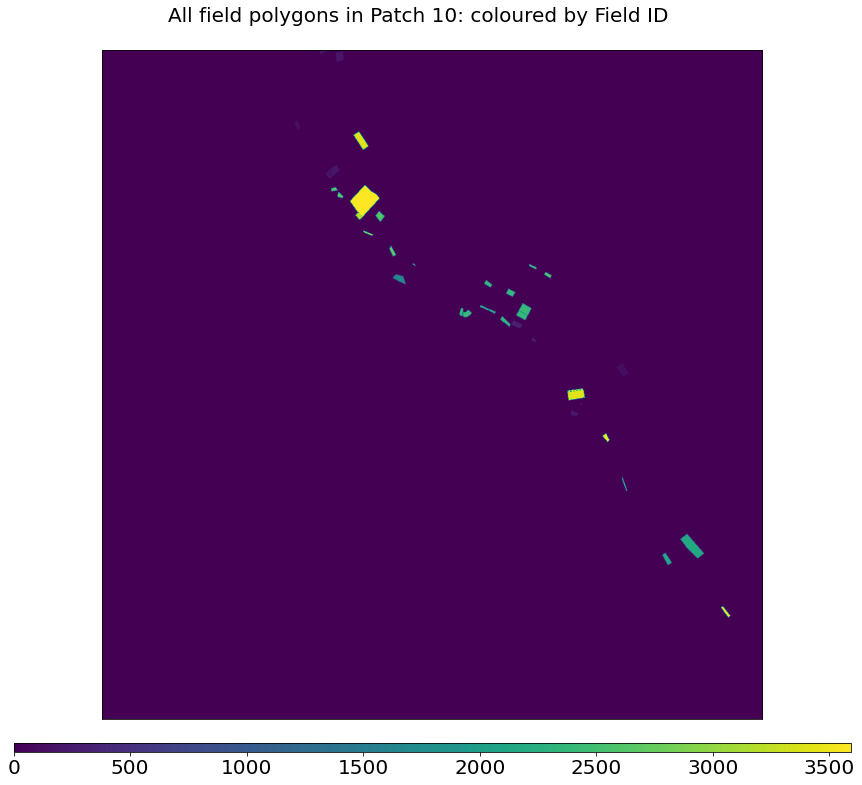

In [ ]:
patch_idx=10

test_field_ids = EOPatch.load(feature_path/f'eopatch_{patch_idx}').mask_timeless['FIELD_ID_TEST'].squeeze()

fig = plt.figure(figsize=(15,15))
im = plt.imshow(test_field_ids)
plt.xticks([])
plt.yticks([])

fig.suptitle(f'All field polygons in Patch {patch_idx}: coloured by Field ID', y=0.92, size=20)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.03, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

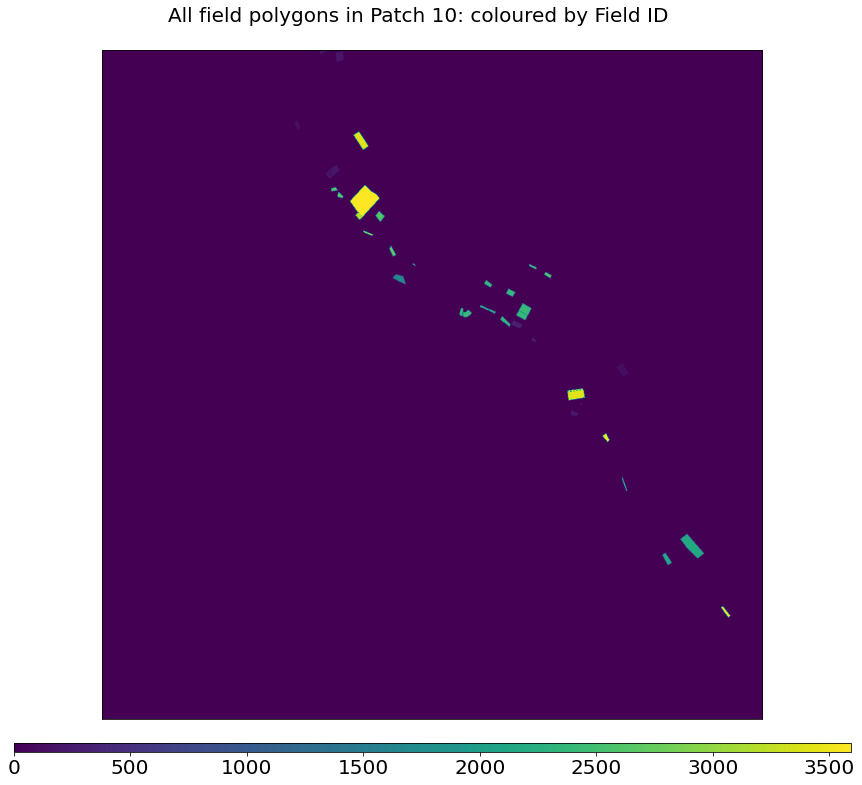

In [ ]:
patch_idx=10

test_field_ids = EOPatch.load(feature_path/f'eopatch_{patch_idx}').mask_timeless['FIELD_ID_TEST'].squeeze()

fig = plt.figure(figsize=(15,15))
im = plt.imshow(test_field_ids)
plt.xticks([])
plt.yticks([])

fig.suptitle(f'All field polygons in Patch {patch_idx}: coloured by Field ID', y=0.92, size=20)

cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.03, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

In [28]:
def display_test_grid(patch_idx, patchlet_path, shape_x=1335, shape_y=1353, size=64):
    
    fig = plt.figure(figsize=(15,15))
    
    patchlet_path = Path(patchlet_path)
    
    c = (shape_x//size)+1
    r = (shape_y//size)+1

    for i in range(r):
        for j in range(c):
            x_offset = i*size
            y_offset = j*size
            
            ax = plt.subplot(r, c, i*c + j+1)

            plt.xticks([])
            plt.yticks([])
            ax.set_aspect("auto")
            
            field_id_fn = Path(patchlet_path/f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl')

            if field_id_fn.exists():
                patchlet = pkl.load(open(field_id_fn,'rb'))
                im = plt.imshow(patchlet.squeeze(),vmin=0,vmax=3600)
    
                                
    cb = fig.colorbar(im, ax=fig.axes, orientation='horizontal', pad=0.5, aspect=100)
    fig.suptitle(f'Grid of all field polygons in Patch {patch_idx}: coloured by Field ID', y=0.92, size=20)
                                
    cb.ax.tick_params(labelsize=20)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

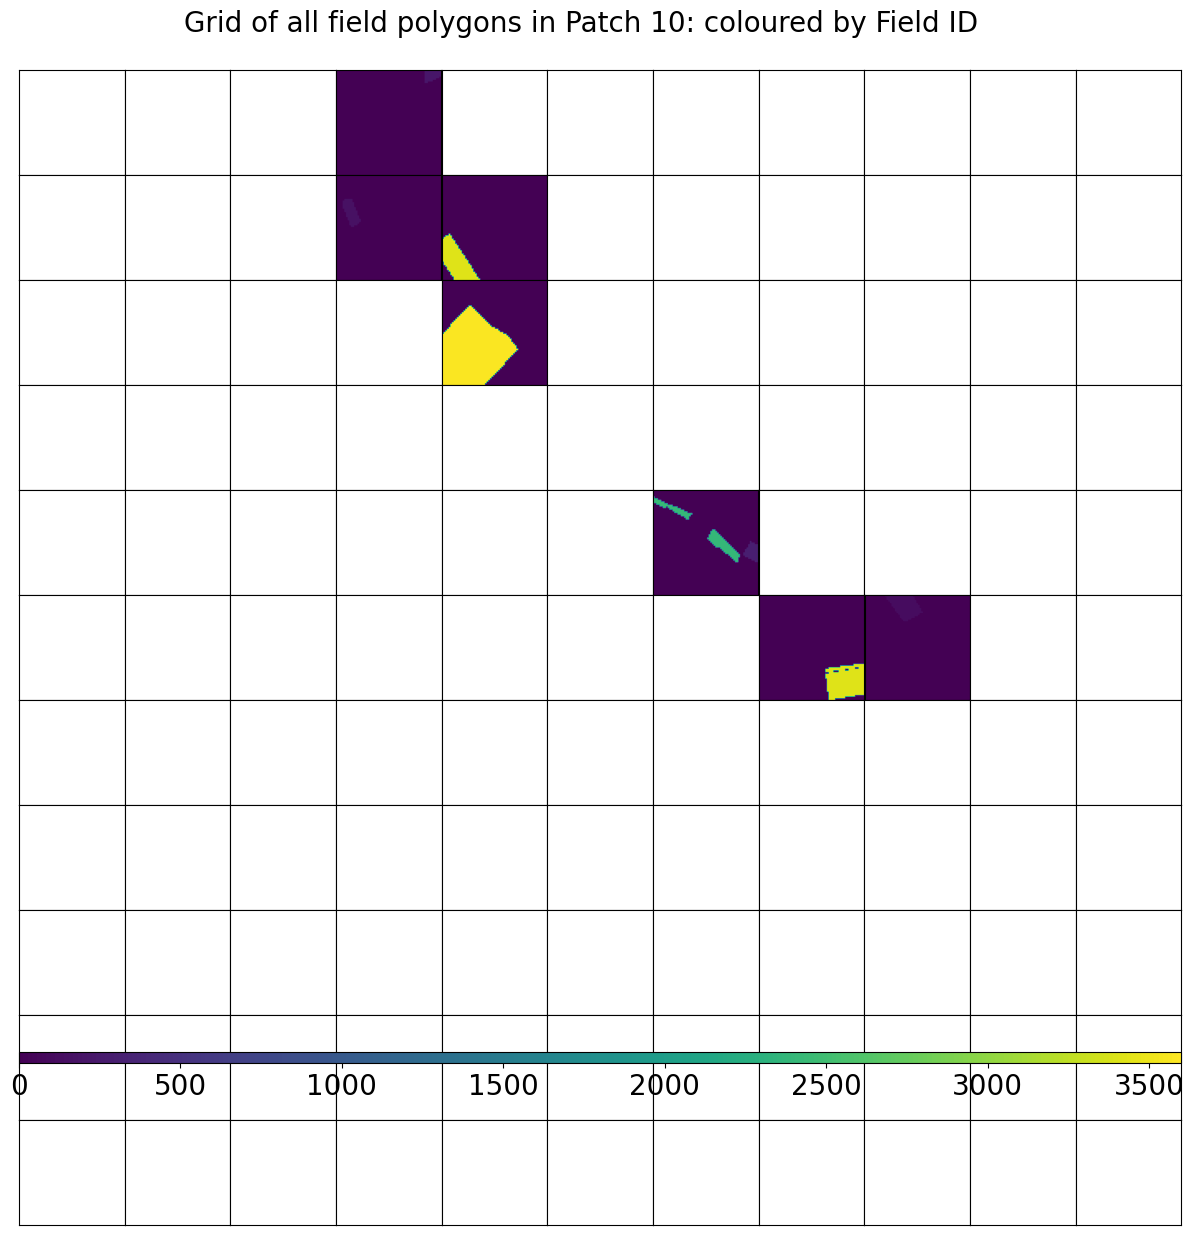

In [29]:
display_test_grid(patch_idx=10, patchlet_path=test_patchlet_path, shape_x=1346, shape_y=1329, size=128)